In [1]:
from IPython.display import clear_output, display
from time import sleep
import numpy as np
print('numpy: %s' % np.__version__) # print version

# Note, need to 'pip install gym', and 'pip install gym[toy_text]' 
# or use 'pip install gym\[toy_text\]' if zsh does not recongize the other command
import gym # for simulated environments
print('gym: %s' % gym.__version__) # print version

import matplotlib
import matplotlib.pyplot as plt # for displaying environment states
print('matplotlib: %s' % matplotlib.__version__) # print version
from IPython import display # for displaying environment states

numpy: 1.23.5
gym: 0.26.1
matplotlib: 3.7.1


### Initialize and validate the environment

In [2]:
# Setup the environment
env = gym.make(id='Taxi-v3', # choose one of the existing environments
               max_episode_steps=None, # default=None, Maximum length of an episode (TimeLimit wrapper).
               autoreset=False, # default=None, Whether to automatically reset the environment after each episode (AutoResetWrapper).
               disable_env_checker=None, # default=None, If to run the env checker
               render_mode = 'rgb_array' # The set of supported modes varies per environment. (And some third-party environments may not support rendering at all.)
              )

State space: Discrete(500)
Action space: Discrete(6)
State: 304
Action: 0
Action mask: [1 1 0 0 0 0]
Reward: -1


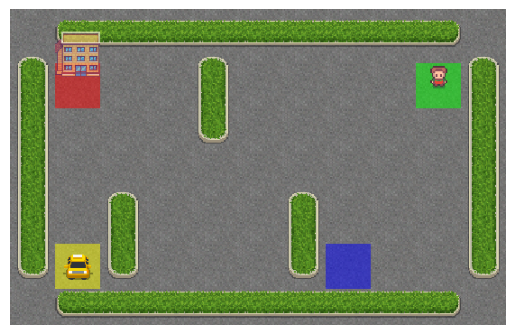

In [3]:
state, _ = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(env.action_mask(state)))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

In [4]:
# Show environment description (map) as an array
print("Environment Array: ")
print(env.desc)

Environment Array: 
[[b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']
 [b'|' b'R' b':' b' ' b'|' b' ' b':' b' ' b':' b'G' b'|']
 [b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b':' b' ' b':' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b'|']
 [b'|' b'Y' b'|' b' ' b':' b' ' b'|' b'B' b':' b' ' b'|']
 [b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']]


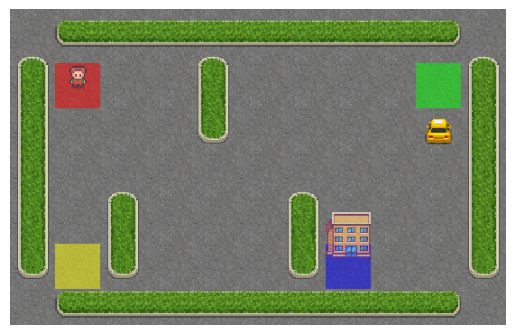

In [5]:
# Reset environment to initial state
state, info = env.reset()
# Cycle through 30 random steps redering and displaying the agent inside the environment each time
for _ in range(30):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Sample a random action from the entire action space
    random_action = env.action_space.sample()
    
    # Pass the random action into the step function
    state, reward, done, _, info = env.step(random_action)
    
    # Reset environment when done=True, i.e., when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display current state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        # Reset environment
        state, info = env.reset()

# Close environment 
env.close()


In [20]:
# SARSA parameters
alpha = 0.1   # learning rate
gamma = 0.95  # discount factor

# Training parameters
n_episodes = 10000  # number of episodes to use for training
n_max_steps = 100   # maximum number of steps per episode

# Exploration / Exploitation parameters
start_epsilon = 1.0  # start training by selecting purely random actions
min_epsilon = 0.0   # the lowest epsilon allowed to decay to
decay_rate = 0.001   # epsilon will gradually decay so we do less exploring and more exploiting as Q-function improves

In [7]:
# Initial Q-table
# Our Q-table is a matrix of state(observation) space x action space, i.e., 500 x 6
Qtable = np.zeros((env.observation_space.n, env.action_space.n))

# Show
Qtable

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [8]:
# This is our acting policy (epsilon-greedy), which selects an action for exploration/exploitation during training
def epsilon_greedy(Qtable, state, epsilon):
    # Generate a random number and compare to epsilon, if lower then explore, otherwise exploit
    randnum = np.random.uniform(0, 1)
    if randnum < epsilon:
        action = env.action_space.sample()    # explore
    else:
        action = np.argmax(Qtable[state, :])  # exploit
    return action

  
# This function is to update the Qtable.
# It is also based on epsilon-greedy approach because the next_action is decided by epsilon-greedy policy
def update_Q(Qtable, state, action, reward, next_state, next_action):
    # 𝑄(𝑆𝑡,𝐴𝑡)=𝑄(𝑆𝑡,𝐴𝑡)+𝛼[𝑅𝑡+1+𝛾𝑄(𝑆𝑡+1,𝐴𝑡+1)−𝑄(𝑆𝑡,𝐴𝑡)]
    Qtable[state][action] = Qtable[state][action] + alpha * (reward + gamma * (Qtable[next_state][next_action]) - Qtable[state][action])
    return Qtable
  
  
# This function (greedy) will return the action from Qtable when we do evaluation
def eval_greedy(Qtable, state):
    action = np.argmax(Qtable[state, :])
    return action

In [9]:
is_notebook = 'inline' in matplotlib.get_backend()

if is_notebook:
    from IPython import display
def moving_average(x: list, periods: int = 5) -> list:
    if len(x) < periods:

        return x

    cumsum = np.cumsum(np.insert(x, 0, 0))
    res = (cumsum[periods:] - cumsum[:-periods]) / periods

    return np.hstack([x[:periods - 1], res])


In [22]:
def plot_durations(episode_durations: list,
                   reward_in_episode: list,
                   epsilon_vec: list,
                   max_steps_per_episode: int) -> None:
    '''Plot graphs containing Epsilon, Rewards, and Steps per episode over time'''
    lines = []
    fig = plt.figure(1, figsize=(15, 7))
    plt.clf()
    ax1 = fig.add_subplot(111)

    plt.title(f'Training...')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Duration & Rewards')
    ax1.set_ylim(-2 * max_steps_per_episode, max_steps_per_episode + 10)
    ax1.plot(episode_durations, color="C1", alpha=0.2)
    ax1.plot(reward_in_episode, color="C2", alpha=0.2)
    mean_steps = moving_average(episode_durations, periods=5)
    mean_reward = moving_average(reward_in_episode, periods=5)
    lines.append(ax1.plot(mean_steps, label="steps", color="C1")[0])
    lines.append(ax1.plot(mean_reward, label="rewards", color="C2")[0])

    ax2 = ax1.twinx()
    ax2.set_ylabel('Epsilon')
    lines.append(ax2.plot(epsilon_vec, label="epsilon", color="C3")[0])
    labs = [l.get_label() for l in lines]
    ax1.legend(lines, labs, loc=3)
    plt.savefig('SARSA_graph_decay_0001.png')
    if is_notebook:
        display.clear_output(wait=True)
    else:
        plt.show()
    plt.pause(0.001)

    return


In [23]:
def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    total_reward = []
    steps_per_episode = []
    epsilon_vec = []
    
    reward = 0
    
    for episode in range(n_episodes):
        total_reward.append(0)
        steps_per_episode.append(0)
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False

        # Calculate epsilon value based on decay rate
        epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        epsilon_vec.append(epsilon)
        
        # Choose an action using previously defined epsilon-greedy policy
        action = epsilon_greedy(Qtable, state, epsilon)
        
        for t in range(n_max_steps):
            
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, _, info = env.step(action)
            total_reward[episode] += reward
            steps_per_episode[episode] += 1
            
            # Choose next action
            next_action=epsilon_greedy(Qtable, next_state, epsilon)
            
            # Update Q-table
            Qtable = update_Q(Qtable, state, action, reward, next_state, next_action)
            
            # Update current state 
            state = next_state
            action = next_action
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
    
    plot_durations(steps_per_episode,
                   total_reward,
                   epsilon_vec,
                   200)

    # Return final Q-table
    return Qtable

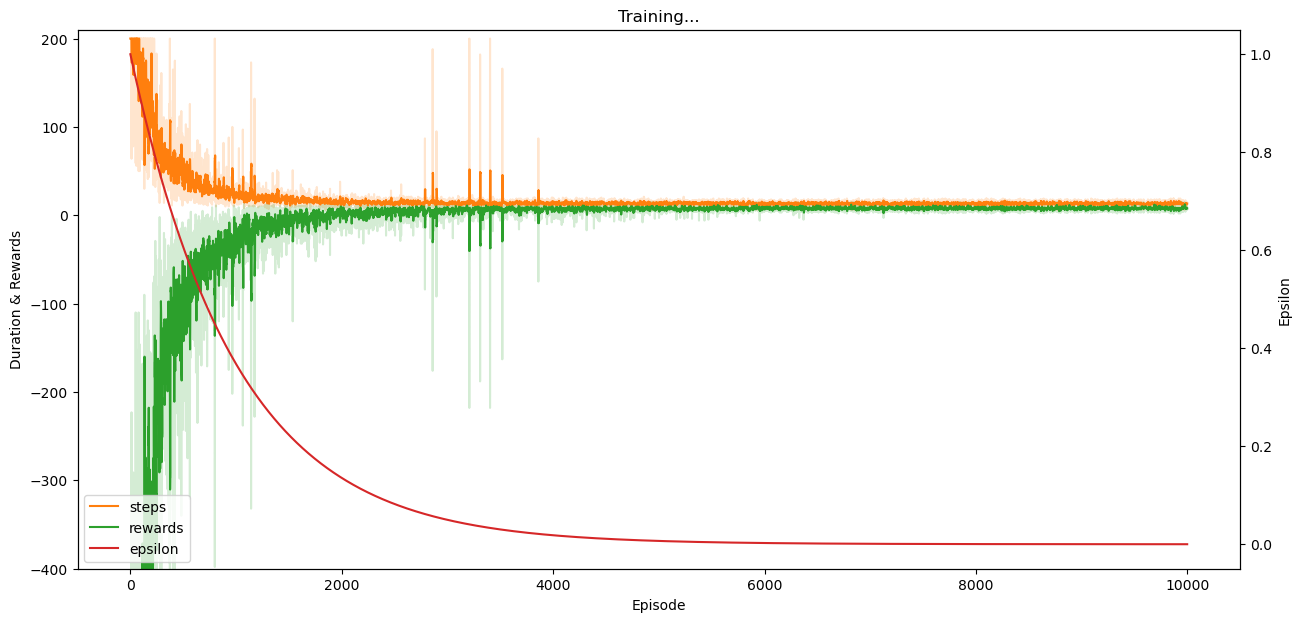

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [-21.16213593, -20.11913475, -21.25942943, -17.86478164,
          5.20997639, -27.0467503 ],
       [-16.80696154, -10.63367566, -15.88783678, -10.99890113,
         10.9512375 , -20.62279847],
       ...,
       [-18.89597189,  -8.44988267, -16.27655495, -14.20584383,
        -26.75142299, -27.51450199],
       [-31.34135394, -28.26653783, -29.83119767, -17.65080039,
        -40.05102449, -37.49256942],
       [  7.63915789,   2.76133334,   9.85391082,  18.        ,
         -1.47465226,  -0.17050509]])

In [24]:
# Train
Qtable = train(n_episodes, 200, start_epsilon, min_epsilon, decay_rate, Qtable)

# Show Q-table
Qtable

In [116]:
# saving qtable
np.save("qtable",Qtable)

In [117]:
def evaluate_agent(n_max_steps, n_eval_episodes, Qtable):
    # Initialize an empty list to store rewards for each episode
    episode_rewards=[]
    
    # test environment variables
    total_epochs = 0
    
    # Evaluate for each episode
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False
        tot_episode_reward = 0
        epochs = 0
        
        for t in range(n_max_steps):
            
            # Use greedy policy to evaluate
            action = eval_greedy(Qtable, state)

            # Pass action into step function
            next_state, reward, done, _, info = env.step(action)

            # Sum episode rewards
            tot_episode_reward += reward

            # Update current state 
            state = next_state
            
            epochs += 1
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
                
        total_epochs += epochs
                
        episode_rewards.append(tot_episode_reward)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    print(f"Average timesteps per episode: {total_epochs / n_eval_episodes}")

    return mean_reward, std_reward, episode_rewards

Average timesteps per episode: 13.0493
Mean Reward = 7.95 +/- 2.57
Min = 3.0 and Max 15.0


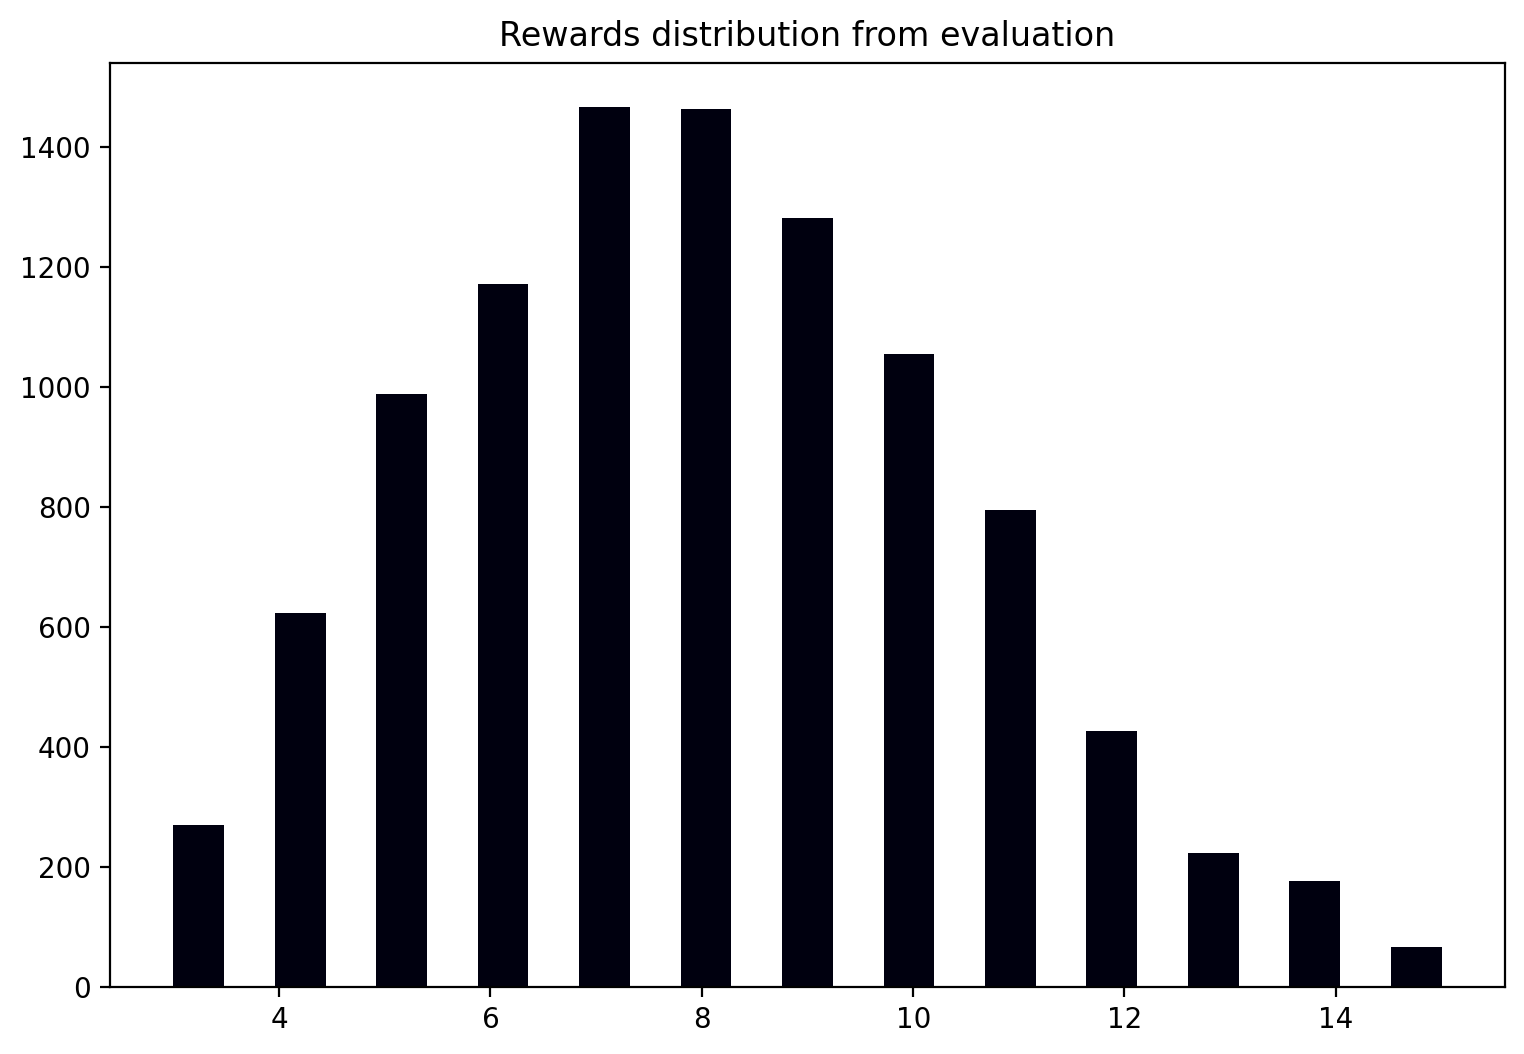

In [122]:
# Evaluate
n_eval_episodes=10000
mean_reward, std_reward, episode_rewards = evaluate_agent(n_max_steps, n_eval_episodes, Qtable)

# Print evaluation results
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")
print(f"Min = {min(episode_rewards):.1f} and Max {max(episode_rewards):.1f}")


# Show the distribution of rewards obtained from evaluation
plt.figure(figsize=(9,6), dpi=200)
plt.title(label='Rewards distribution from evaluation', loc='center')
plt.hist(episode_rewards, bins=25, color='#00000f')
plt.show()

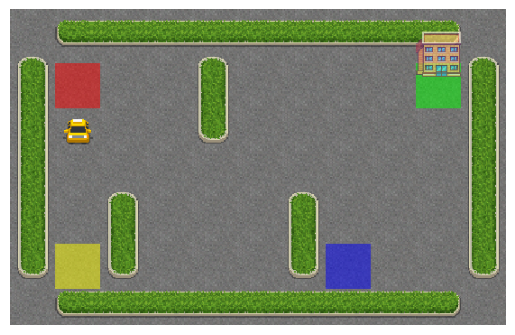

In [120]:
# Reset environment to initial state
state, info = env.reset()

# Cycle through 50 steps redering and displaying environment state each time
for _ in range(50):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Use greedy policy to evaluate
    action = eval_greedy(Qtable, state)
    
    # Pass action into step function
    state, reward, done, _, info = env.step(action)
    
    # Reset environment when done=True, i.e. when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display final state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        state, info = env.reset()

env.close()